Empirical Bayes

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

We divide the target variable (quality) into 3 classes.
- Class 0 : Bad (quality <= 4)
- Class 1 : Average (5 <= quality <= 7)
- Class 2 : Good (8 <= quality)

In [2]:
# Load data
df_white = pd.read_csv('winequality-white.csv', delimiter=';')
df_red = pd.read_csv('winequality-red.csv')

# Select dataset
df = df_white
#df = df_red

# Create a quality label (low, medium, high) based on quality score
df['quality_label'] = df['quality'].apply(lambda x: 'Poor' if x < 5 else 'Average' if x <= 7 else 'High')

# Encode 'quality_label' to numerical values
label_enc = LabelEncoder()
df['quality_label'] = label_enc.fit_transform(df['quality_label'])

df = df.drop_duplicates()

# Separate the data into features and target
X = df.drop(['quality', 'quality_label'], axis=1).to_numpy()
y = df['quality_label'].to_numpy()

In [3]:
# Initialize scaler
rb_scaler = RobustScaler()

# Split the data into training and testing sets FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the data after to prevent data leakage
X_train = rb_scaler.fit_transform(X_train)
X_test = rb_scaler.transform(X_test)

#### Optimal Bayes

In [4]:
from scipy.stats import norm

class BayesOptimalClassifier:
    def __init__(self):
        self.class_priors = {}
        self.class_conditional_dists = {}

    def fit(self, X, y):
        """Train the classifier by computing priors and likelihoods"""
        n_samples, _ = X.shape
        classes = np.unique(y)

        # Compute class priors P(C_k)
        class_counts = Counter(y)
        self.class_priors = {c: class_counts[c] / n_samples for c in classes}

        # Compute P(X | C_k) assuming Gaussian distributions for each feature
        self.class_conditional_dists = {}
        for c in classes:
            X_c = X[y == c]
            self.class_conditional_dists[c] = {
                "mean": X_c.mean(axis=0),
                "std": X_c.std(axis=0, ddof=1) + 1e-9  # Avoid division by zero
            }

    def predict_proba(self, X):
        """Compute posterior probabilities for each class"""
        X = np.asarray(X)  # Ensure X is a numpy array
        classes = list(self.class_priors.keys())  # Get sorted class labels
        num_samples = X.shape[0]
        num_classes = len(classes)
        
        # Initialize probability matrix
        proba_matrix = np.zeros((num_samples, num_classes))
        
        for idx, c in enumerate(classes):
            prior = self.class_priors[c]
            mean = self.class_conditional_dists[c]["mean"]
            std = self.class_conditional_dists[c]["std"]
            
            # Compute likelihoods for all samples
            likelihoods = np.prod(norm.pdf(X, mean, std), axis=1)
            proba_matrix[:, idx] = prior * likelihoods
        
        # Normalize probabilities
        proba_matrix /= proba_matrix.sum(axis=1, keepdims=True)
        
        return proba_matrix

    def predict(self, X):
        """Predict the most probable class for each instance."""
        proba_matrix = self.predict_proba(X)
        classes = list(self.class_priors.keys())
        return np.array([classes[i] for i in np.argmax(proba_matrix, axis=1)])

In [5]:
model = BayesOptimalClassifier()
model.fit(X_train, y_train)

### Evaluation

In [6]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Encoded Quality Labels:\n', dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_))))
print('\n',classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy*100:.2f} %')


Encoded Quality Labels:
 {'Average': 0, 'High': 1, 'Poor': 2}

               precision    recall  f1-score   support

           0       0.94      0.87      0.90      1096
           1       0.13      0.37      0.19        41
           2       0.25      0.27      0.26        52

    accuracy                           0.83      1189
   macro avg       0.44      0.50      0.45      1189
weighted avg       0.88      0.83      0.85      1189

Accuracy: 82.67 %


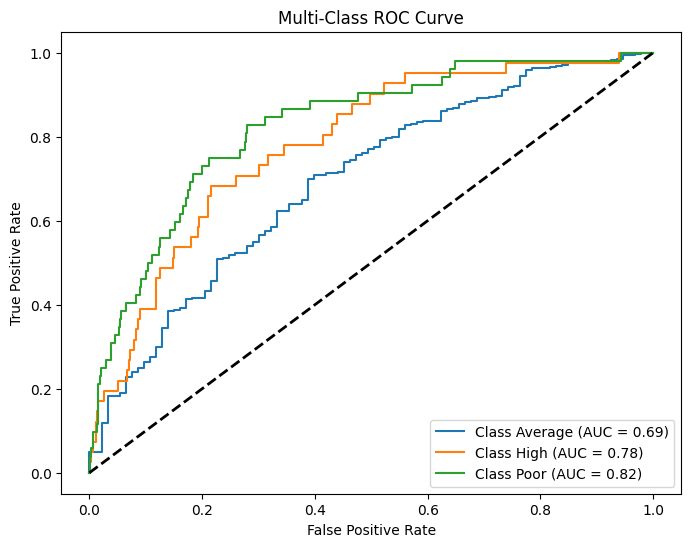

In [7]:
# Convert y_test and y_pred to binary format for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # One-hot encode labels
y_score = model.predict_proba(X_test)  # Get probability scores for each class

# Number of classes
n_classes = y_test_bin.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_enc.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


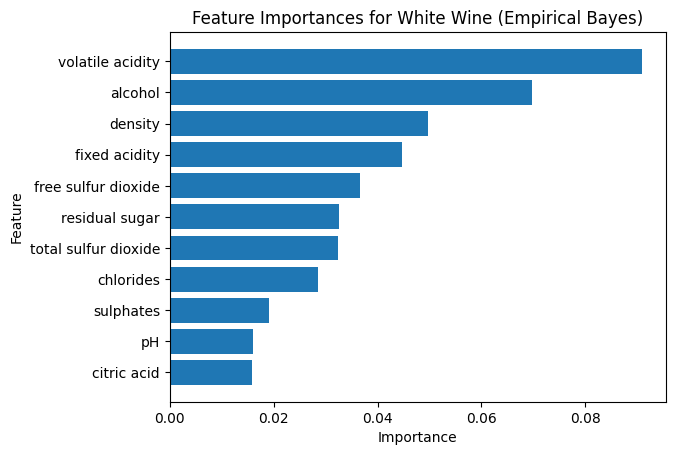

In [15]:
def get_feature_importances(model, X, feature_names):
    classes = list(model.class_priors.keys())
    n_features = X.shape[1]

    global_mean = np.mean(X, axis=0)
    global_std = np.std(X, axis=0, ddof=1) + 1e-9

    feature_importances = np.zeros(n_features)

    for c in classes:
        class_prior = model.class_priors[c]
        class_mean = model.class_conditional_dists[c]["mean"]

        importance_c = class_prior * np.abs(class_mean - global_mean) / global_std
        feature_importances += importance_c

    df_importance = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
    df_importance = df_importance.sort_values(by="Importance", ascending=False)
    
    return df_importance

feature_names = df.columns.drop(['quality', 'quality_label'])
df_importance = get_feature_importances(model, X_train, feature_names)

plt.barh(df_importance['Feature'][::-1], df_importance['Importance'][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances for White Wine (Empirical Bayes)")
plt.show()